# Deep Learning with Autoencoders unsupervised

Autoencoders are deep neural networks used to reproduce the input at the output layer i.e. the number of neurons in the output layer is exactly the same as the number of neurons in the input layer. Consider the image below

## AutoEncoder Architecture

![autoencoders](datasets/autoencoder-architecture.jpg)


This image represents the structure of a typical deep autoencoder. The goal of an autoencoder architecture is to create a representation of the input at the output layer such that both are as close (similar) as possible. But, the actual use of autoencoders is for determining a compressed version of the input data with the lowest amount of loss in data. 

In [1]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, precision_recall_fscore_support, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


In [2]:
train_split = 0.80
nrows = 1_000_000
path = 'c:/users/ugy1/abs/'
df=pd.read_csv(path+'datasets/processed_abs_loan_'+str(nrows)+'.csv', 
               #usecols=use_list, 
               #sep='\t',
               #compression=bz2,
               nrows=nrows,
               low_memory=False, 
              index_col=0, 
               parse_dates=True
              )
df.shape

(913751, 85)

In [3]:
df.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,zerobalance_[],"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,label
0,11940.46,60,0.2149,1,573.0,0.169781,6160.80,1225.49,0.2149,0.2149,...,1,0,0,0.0107,1.10,3.44,0.68,1.22,0.91,1.0
1,17501.22,62,0.0190,2,814.0,0.061246,4925.58,0.00,0.0190,0.0190,...,1,0,0,0.0100,1.00,3.31,0.75,0.57,0.94,0.0
2,13310.93,72,0.1897,2,578.0,0.050482,13310.93,463.85,0.1729,0.1729,...,1,0,0,0.0107,1.10,3.44,0.68,1.22,0.91,0.0
3,21427.33,72,0.0651,1,581.0,0.041312,20936.74,793.31,0.0651,0.0651,...,1,0,0,0.0107,1.10,3.44,0.68,1.22,0.91,0.0
4,6200.00,60,0.1868,1,614.0,0.092229,6200.00,239.06,0.1868,0.1868,...,1,0,0,0.0105,1.05,3.22,0.74,0.51,0.94,0.0


In [4]:
column_list=df.columns.tolist()

In [5]:
# prepare label for scikit-learn
Y=df.label.values
Y.shape

(913751,)

In [6]:
# prepare input data for scikit-learn
input=df.values
input.shape

(913751, 85)

In [7]:
# calculate train/test split

len_train = int(len(input)*train_split)
print(len_train)

731000


In [8]:
# apply train/test split to labels
y_train = Y[0:len_train]
y_test = Y[len_train:]
x_train = input[0:len_train]
x_test = input[len_train:]
x_train.shape

(731000, 85)

In [9]:
#from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer

In [10]:
x_scaler=StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.fit_transform(x_test)

In [11]:
nb_epoch = 100
batch_size = 512
input_dim = x_train.shape[1] 
encoding_dim = 254
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)

encoder = Dense(16, activation="relu")(encoder)
decoder = Dense(16, activation='tanh')(encoder)

decoder = Dense(hidden_dim, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [12]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="./model/autoencoder_abs_loan.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(x_train, x_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 731000 samples, validate on 182751 samples
Epoch 1/100
731000/731000 [==============================] - 18s 25us/step - loss: 0.4306 - acc: 0.7267 - val_loss: 0.3577 - val_acc: 0.7933
Epoch 2/100
731000/731000 [==============================] - 18s 24us/step - loss: 0.3506 - acc: 0.8027 - val_loss: 0.3423 - val_acc: 0.7967
Epoch 3/100
731000/731000 [==============================] - 19s 25us/step - loss: 0.3419 - acc: 0.8073 - val_loss: 0.3367 - val_acc: 0.8046
Epoch 4/100
731000/731000 [==============================] - 17s 23us/step - loss: 0.3390 - acc: 0.8107 - val_loss: 0.3363 - val_acc: 0.8092
Epoch 5/100
731000/731000 [==============================] - 18s 24us/step - loss: 0.3383 - acc: 0.8123 - val_loss: 0.3366 - val_acc: 0.8337
Epoch 6/100
731000/731000 [==============================] - 18s 25us/step - loss: 0.3361 - acc: 0.8144 - val_loss: 0.3323 - val_acc: 0.8416
Epoch 7/100
731000/731000 [==============================] - 18s 24us/step - loss: 0.3367 - acc: 0.815

In [13]:
autoencoder = load_model('model/autoencoder_abs_loan.h5')

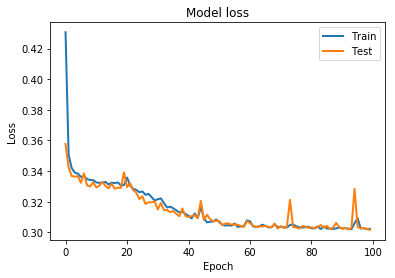

In [14]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [15]:
x_test_predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - x_test_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.describe()

,Reconstruction_error,True_class
count,182751.000000,182751.000000
mean,0.300392,0.088558
std,3.292030,0.284105
min,0.094887,0.000000
25%,0.180435,0.000000
50%,0.226649,0.000000
75%,0.310597,0.000000
max,717.960309,1.000000


In [16]:
x_test_predictions[0]

array([0.        , 0.8198939 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.424024  , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.1615336 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       2.2225337 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.228964  ,
       0.        , 1.5436376 , 0.        , 0.        , 0.        ,
       0.        , 0.4786135 , 1.0687988 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.5445888 , 0.        , 0.        ,
       0.        , 0.22138798, 0.        , 0.        , 0.        ,
       0.27685004, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.31684422, 0.        , 0.        , 0.     

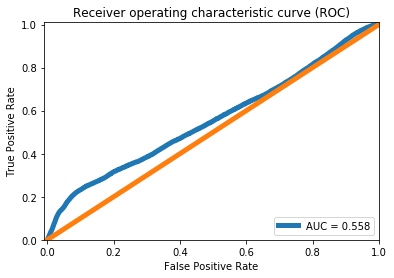

In [17]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

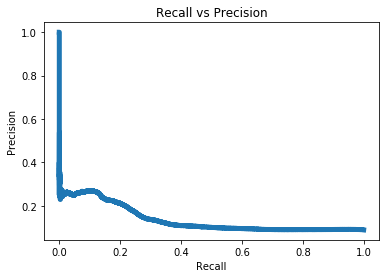

In [18]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

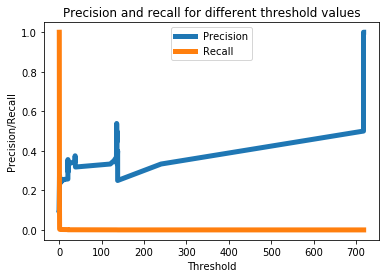

In [19]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

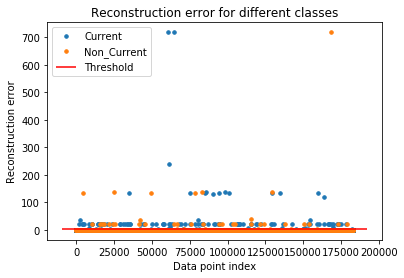

In [20]:
threshold_fixed = 5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Non_Current" if name == 1 else "Current")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

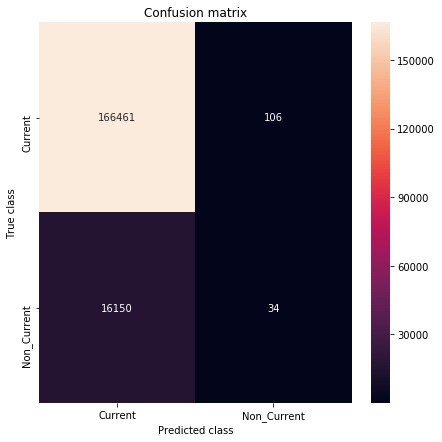

In [21]:
LABELS=['Current', 'Non_Current']
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()